# Bermudan-Asian Option Pricing using Regression and Machine Learning Techniques
In this notebook, we will explore the use of various __monte-carlo methods__ used to price Bermudan-Asian options. In particular, we will be looking at __regression-based algorithms__ proposed by [Tsitsiklis-Van Roy (1997)](https://pubmed.ncbi.nlm.nih.gov/18249905/) and [Longstaff-Schwartz (2001)](https://escholarship.org/uc/item/43n1k4jb), the __duality-based method__ by [Broadie and Andersen (2004)](https://econpapers.repec.org/article/inmormnsc/v_3a50_3ay_3a2004_3ai_3a9_3ap_3a1222-1234.htm), the __machine learning-based algorithms__ by [Lapeyre & Lelong (2021)](https://arxiv.org/abs/1907.06474) and [Ech-chafiq, Labodere & Lelong (2022)](https://arxiv.org/abs/2201.02587). The contents are organized as such:  

1. We give a preliminary overview of Bermudan-Asian options, and briefly explore the pricing algorithms we will be using in the subsequent sections. 

2. We explore the primal problem to obtain the lower bound price of a Bermudan-Asian option.

3. We explore the dual problem to obtain the upper bound price of a Bermudan-Asian option. 

4. We explore machine learning techniques (e.g. feed-forward neural network, random forest, gradient boosting trees etc.) in pricing Bermudan-Asian options, and make a preliminary assessment of the effeciveness of ML techniques in option pricing. 

5. We conclude by comparing the computational efficiency and accuracy of techniques introduced above against the finite difference method. 

## 0. Setup

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
from scipy.stats import norm

np.random.seed(123) # for replication

plt.rc('figure', figsize=(6, 5.5))
plt.rc('axes', grid=True, xmargin=0, ymargin=0, autolimit_mode='round_numbers')

## 1. Bermudan-Asian Option Payoff and Pricing

__Bermudan options__ are early exercise options in which buyers have the right to exercise at predetermined dates before maturity date $T$ (often in one-month increments). We can view them as simply American options with discrete and fixed exercising dates. A Bermudan option is priced between an American option and an European option, given the same parameters. The most basic forms of Bermudan options are Bermudan call and put options, which can be generalized as such: 

1. At time t, an investor pays $V(t)$ for a unit of Bermudan option. 
2. At time T, the investor has the final chance to exercise her option, receiving a payoff $V(T) = (K-S(T))^+$ for a put or $V(T) = (S(T)-K)^+$ for a call.
3. Between time t and T, the investor has n-1 opportunities at $t_i , i \in \{ 1,2,...,n-1 \} $ to exercise her option and receive a payoff $V(t_i) = (K-S(t_i))^+$ for a put or $V(t_i) = (S(t_i)-K)^+$ for a call.

__Asian options__ are options where their payoff depend on the average price of the underlying asset over a certain period of time. They can be structured as alternative versions of American, European or Bermudan options. Naturally, Asian options have lower premium than their vanilla counterparts, as the volatility of the underlying assets are dampened by the averaging feature. The method of averaging can be either geometric mean, arithmetic mean, harmonic mean, or others. Also, Asian options can be further divided into fixed strike (averaging over underlying price) or floating strike (averaging over strike) options. 

In this notebook, we will mainly concern ourselves with the pricing of __fixed strike Bermudan-Asian options with arithmetic averaging__.

### 1a. Mathematical Model
We assume that the underlying security price follows the geometric Brownian motion

$$\frac{dS_t}{S_t}=(r-q)dt+\sigma dW_t$$

with $S_0=100$, $r=0.02$, $q=0.01$ and $\sigma=0.2$. The option has a strike of $K=100$ and a final expiration date of $T=1$ and can be exercised every month before the final maturity, i.e.
$$t_1=\frac{1}{12},\, t_2=\frac{2}{12},\, \ldots,\, t_{12}=1$$

The cashflow from exercising the option at time $t_i$, $i=1,\ldots,12$, is $\max\left(0, A(t_i)-K\right)$ with $A(t_i)=\frac{1}{n}\sum_{i=1}^nS(t_i)$.

In [4]:
def blackscholes_mc(S=100, vol=0.2, r=0, q=0, ts=np.linspace(0, 1, 13), npaths=10):
    nsteps = len(ts) - 1
    ts = np.asfarray(ts)[:, np.newaxis]
    W = np.cumsum(np.vstack((np.zeros((1, npaths), dtype=np.float),
                             np.random.randn(nsteps, npaths) * np.sqrt(np.diff(ts, axis=0)))),
                  axis=0)
    paths = np.exp(-0.5*vol**2*ts + vol*W)*S*np.exp((r-q)*ts)
    return paths
    

def blackscholes_price(K, T, S, vol, r=0, q=0, callput='call'):
    F = S*np.exp((r-q)*T)
    v = np.sqrt(vol**2*T)
    d1 = np.log(F/K)/v + 0.5*v
    d2 = d1 - v
    try:
        opttype = {'call':1, 'put':-1}[callput.lower()]
    except:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = opttype*(F*norm.cdf(opttype*d1)-K*norm.cdf(opttype*d2))*np.exp(-r*T)
    return price

In [5]:
# initializing parameters
S0, vol, r, q, K, T = 100, 0.2, 0.02, 0.01, 100, 1
ts = np.linspace(0, 1, 13)
n_paths = 10000

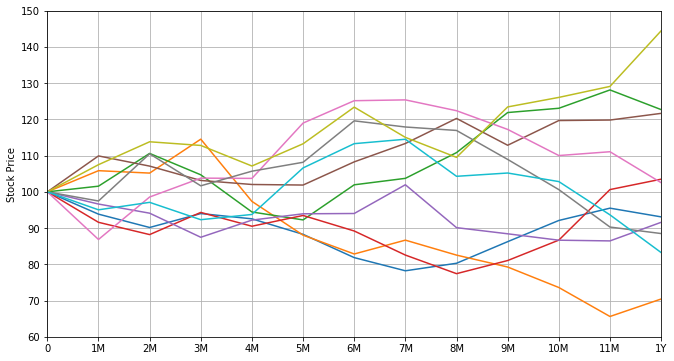

In [6]:
paths = blackscholes_mc(S0, vol, r, q, ts)
fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(ts, paths[:, :10])
ax.set_xticks(ts)
ax.set_xticklabels(['0', '1M', '2M', '3M', '4M', '5M', '6M', '7M', '8M', '9M', '10M', '11M', '1Y'])
ax.set_ylabel('Stock Price')
ax.grid(True)

### 1b. Primal-Dual Problem

Just like the pricing of other exotic options, we can view the price of Bermudan-Asian options as the convergence of two optimization problems: primal and dual.

In the __primal problem__, we are concerned with the buyer's decision to optimally exercise her option on one of the exercise dates $t_i$. This can be modelled as a stopping time problem, in which we seek to find the optimal stopping rule $\tau^*$ that maximizes the expected payoff of the option. That is, 
$$V_t = \sup_{\tau \in \mathcal{T}_{t,T}} \mathbb{E}^\mathbb{Q}\left[D_{t,\tau}F_{\tau}|\mathcal{F}_t\right]$$
where $F_{\tau}$ denote the payoff of exercising the option at time $\tau$, $D_{t,\tau}$ denote the discount factor at time $\tau$ with respect to time $t$, $V_t$ denote the value of the option at time $t$. 

Numerically, we can solve the problem as such: 
1. At the final expiry time $t_N = T$, we set $V_{t_N} = F_{t_N}$. 

2. Then, we recursively calculate the value of the option at time $t_i$ as $V_{t_i} = max(\mathbb{E}^\mathbb{Q}\left[D_{t_i,t_{i+1}}V_{t_{i+1}}|\mathcal{F}_{t_i}\right],F_{t_i})$. That is, at each exercise before maturity, we choose whether to exercise or not by comparing between the continuation value $C_{t_i} = \mathbb{E}^\mathbb{Q}\left[D_{t_i,t_{i+1}}V_{t_{i+1}}|\mathcal{F}_{t_i}\right]$ and the exercise value $F_{t_i}$. (_The method for estimating the continuation value $\hat{C}_{t_j}$ is further discussed in part 2_)

3. Next, we collect the optimal stoppping strategy as $$\hat{\tau}^* = \inf_{j=1,\dots,N} \{t_j|F_{t_j}\geq\hat{C}_{t_j}\}$$ that is, the first hitting time where the exercise value is greater than the estimated continuation value

4. Finally, we simulate new independent paths that are stopped according to $\hat{\tau}^*$ and obtain the lower bound price as $V_0 = \mathbb{E}^\mathbb{Q}[D_{0,\hat{\tau}^*}F_{\hat{\tau}^*}]$.

In the __dual problem__, we are concerned with the seller's decision to hedge his position over a set of martingales. Our goal is to find the optimal martingale $M^*$ which gives us the lowest exposure to exercise risk. That is, 
$$V_t = \inf_{M \in \mathcal{M}_{t,0}} \mathbb{E}^\mathbb{Q}\left[\sup_{t\leq s \leq T} (D_{t,s}F_s - M_s|\mathcal{F}_t) \right]$$

where $\mathcal{M}_{t, 0}$ denotes the set of all right-continuous martingales $(M_s, s\in[t, T])$ with $M_t=0$.

In particular, any martingale $M_s$ with $M_0=0$ gives an upper bound for the price at time 0, $V_0$:

$$V_0 \leq\mathbb{E}^{\mathbb{Q}}\left[\sup_{0\leq s\leq T}\left(D_sF_s-M_s\right)\right].$$

It turns out that we can theoretically obtain the optimal martingale, by extracting the martingale component of the Snell envelope of the discounted payoff at each time $t$ via Doob-Meyer decomposition. That is, the optimal martingale $M^{\ast}$ is the martingale part of the Doob-Meyer decomposition of $(S_s-S_t)/D_{0, t}$, $t\leq s\leq T$, where $S$ is the Snell envelope of the discounted payoff, i.e., $S_t=\sup_{\tau\in\mathcal{T}_{t,T}}\mathbb{E}^{\mathbb{Q}}\left[D_{0,\tau}F_{\tau}\right]$.


For more in depth discussion of this topic, please refer to [Rogers (2002)](https://onlinelibrary.wiley.com/doi/10.1111/1467-9965.02010) and [Haugh & Hogan (2004)](https://www.jstor.org/stable/30036577?seq=1)

### 1c. PDE Solver

Bermudan-Asian options are more complex to price than their vanilla counterparts, because not only do they have the American exercise feature, their cash flows from exercise are path dependent since $A_t$ depends on the path of the stock price over the averaging window. In general, these problems pose significant challenge for the classical finite difference techniques. To circumvent these difficulties, we can use finite difference method by transforming the pricing problem from a path dependent one to a Markovian problem. This is done by introducing the average underlying price to date as the second state variable ibn the problem. Therefore, the option price H(S, A, t) is the solution of the following two-dimensional PDE: 
$$(\sigma^2S^2/2)H_{ss} + rSH_s + \frac{1}{t}(S-A)H_A - rH + H_t = 0$$


## 2. Primal Problem

The __Tsitsiklis-van Roy__ and __Longstaff-Schwartz__ algorithms provide an estimate for the expected payoff from continuation at each exercise date from the cross-sectional information in the simulation using regression. By comparing this estimate with the immediate exercise value, the holder of the option can determine whether to exercise the option or continue. 

In this section, we take a look at the effectiveness of different linear regression techniques like __polynomial regression__, __piecewise regression__, __Nadaraya-Watson kernel regression__, and __local regression__ in estimating the conditional expection of option payoff at each timestep, using the cross-sectional asset prices obtained from monte carlo simulation as regressors. Our goal is to obtain the optimal exercise policy which determines the lower bound price. 

### 2a. Longstaff-Schwartz algorithm

The __Least Squares Method (LSM)__ proposed by Longstaff and Schwartz (2001) offers a way to estimate the continuation value using a least square regression of the post realized payoffs from continuation on some basis functions of the state variables. For the basis functions, the authors propose using a constant. the first two Laguene polynomials evaluated at the stock price, the first two Laguerre polynomials evaluated at the average stock 
price, and the cross products of these Laguerre polynomials up to third-order terms, giving us a total of eight basis functions in the regres~ion. Let's see how this recommended approach compares to other versions of regression.

#### Polynomial Regression

Here, we use the following basis functions: 

$$1, A_{t_n}, S_{t_n}, A_{t_n}^2, S_{t_n}^2, A_{t_n}S_{t_n}, A_{t_n}^2S_{t_n}^2, A_{t_n}^3S_{t_n}^3$$

In [316]:
# simulating paths 
exer_func = lambda S : np.maximum(K-S, 0)
pathsS = blackscholes_mc(S0, vol, r, q, ts=ts, npaths=100000)                                  # stock prices
pathsA = np.vstack((pathsS[0], np.cumsum(pathsS[1:], axis=0)/np.arange(1, 13)[:, np.newaxis])) # running averages
payoff = np.maximum(pathsA[-1]-K, 0)
betas_P = np.full((len(ts), 8), np.nan, dtype=np.float)

# stopping policy
def exer_or_cont(i, S, A):
    
    f1 = np.ones_like(A)
    f2 = A
    f3 = S
    f4 = A**2
    f5 = S**2
    f6 = A*S
    f7 = (A**2)*(S**2)
    f8 = (A**3)*(S**3)
    
    Cn = betas_P[i,0]*f1 + betas_P[i,1]*f2 + betas_P[i,2]*f3  + betas_P[i,3]*f4 + betas_P[i,4]*f5 + betas_P[i,5]*f6 + betas_P[i,6]*f7 + betas_P[i,7]*f8
    Fn = np.maximum(A-K, 0)
    return Fn >= Cn

# run independent paths stopped according to stopping policy
def nested_mc(S, A, vol, r, q, i, ts, nnested):
    nested_paths = np.full(nnested, S, dtype=np.float)
    nested_pathsA = np.full(nnested, A, dtype=np.float)
    tot_payoff = 0
    for j in range(i+1, len(ts)):
        dt = ts[j] - ts[j-1]
        dW = np.random.randn(len(nested_paths))*np.sqrt(dt)        # Brownian increment
        nested_paths = nested_paths*np.exp((r-q)*dt)*np.exp(-0.5*vol**2*dt + vol*dW)
        nested_pathsA = (nested_pathsA*(j-1) + nested_paths)/j
        exer_vals =  np.maximum(nested_pathsA-K, 0)
        if j < len(ts)-1:
            ind = exer_or_cont(j, nested_paths, nested_pathsA)                    # identify the paths that need exercise
            tot_payoff += np.sum(exer_vals[ind])*np.exp(-r*ts[j])
            nested_paths = nested_paths[~ind]
            nested_pathsA = nested_pathsA[~ind]                      # remove exercised paths 
            if len(nested_pathsA) == 0:                             # if exercised for all paths, stop
                break
        else:
            tot_payoff +=  np.sum(exer_vals)*np.exp(-r*ts[j])
    return tot_payoff/nnested                                      # taking average of paths

In [192]:
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    
    #basis functions 
    f1 = np.ones_like(pathsA[i])
    f2 = pathsA[i]
    f3 = pathsS[i]
    f4 = pathsA[i]**2
    f5 = pathsS[i]**2
    f6 = pathsA[i]*pathsS[i]
    f7 = (pathsA[i]**2)*(pathsS[i]**2)
    f8 = (pathsA[i]**3)*(pathsS[i]**3)
    
    A = np.vstack((f1, f2, f3, f4, f5, f6, f7, f8)).T
    betas_P[i] = np.linalg.lstsq(A, payoff, rcond=None)[0]           # regression to estimate continuation values
    contval = np.sum(betas_P[i]*A,axis=1)
    exerval = np.maximum(pathsA[i]-K, 0)
    ind = exerval > contval                               # identify the paths where we should exercise
    payoff[ind] = exerval[ind]

# Simulate independent paths and exercise the option according to the fitted optimal stopping rule
V0 = nested_mc(S0, S0, vol, r, q, 0, ts, 5000)

print(f'Lower Bound Price obtained from LSM Polynomial Regression = {V0:.4f}')
print(f'Estimation error:')

Lower Bound Price obtained from LSM Polynomial Regression = 5.1151
Estimation error:


In [193]:
# Upper bound by Andersen-Broadie algorithm
npaths = 500                                                       # number of paths in the second independent run
nnested = 1000                                                     # number of paths used in nested simulation
pathsS = blackscholes_mc(S=S0, vol=vol, r=r, q=q, ts=ts, npaths=npaths)
pathsA = np.vstack((pathsS[0], np.cumsum(pathsS[1:], axis=0)/np.arange(1, 13)[:, np.newaxis])) # running averages
V = np.full(pathsA.shape, np.nan, dtype=np.float)                   # discounted value process V_i (discounted to time zero)
EV = np.full(pathsA.shape, np.nan, dtype=np.float)                  # Conditional expectation E[V_{i+1}|F_i], or continuation value
V[0] = V0                                                          # Initial value from lower bound simulation
EV[0] = V0                                                         # at time 0, option value = continuation value
for i in range(1, len(ts)-1):
    exer_vals =  np.maximum(pathsA[i]-K, 0)         
    ind = exer_or_cont(i, pathsS[i], pathsA[i])                                # True for exercise False for continue
    for j in range(npaths):
        if exer_or_cont(i, pathsS[i,j], pathsA[i,j]):
            V[i, j] = exer_vals[j]*np.exp(-r*ts[i])                     # if exercised, V[i,j] = exercise value
            EV[i,j] = nested_mc(pathsS[i,j],pathsA[i, j], vol, r, q, i, ts, nnested) # launch nested simulation to estimate E[V_{i+1}|F_i]
        else:
            V[i,j] = nested_mc(pathsS[i,j],pathsA[i, j], vol, r, q, i, ts, nnested)  # if continue, use nested simulation to estimate V[i, j]
            EV[i, j] = V[i, j]                                          # E[V_{i+1}|F_i] = V_i
V[-1] = np.maximum(pathsA[-1]-K, 0)*np.exp(-r*ts[-1])                     # values at final maturity
M = np.zeros(pathsA.shape, dtype=np.float)
M[1:] = np.cumsum(V[1:]-EV[:-1], axis=0) 

duality2 = np.mean(np.amax(np.maximum(pathsA[1:]-K, 0)*np.exp(-r*ts[1:, np.newaxis])-M[1:], axis=0)) - V0
print('Dual Price   (Upper Bound) = {:.4f}'.format(np.mean(np.amax(np.maximum(pathsA[1:]-K, 0)*np.exp(-r*ts[1:, np.newaxis])-M[1:], axis=0))))

Dual Price   (Upper Bound) = 5.6584


#### Regression with different basis function
Here, we use the following basis functions: 
$$1, C_{BS}$$
where $C_{BS}$ denote the Black-Scholes value of a European call option with strike $K$, maturity $T-t_n$, volatility $\bar\sigma = 0.1$, and the spot value $Z_{t_n}\equiv \frac{nA_{t_n}+(12-n)S_{t_n}}{12}$.

In [244]:
# stopping policy
def exer_or_cont2(i, S, A, vol_):
    Z = (i*A+(12-i)*S)/12
    callZ = blackscholes_price(K, ts[-1]-ts[i], Z , vol, callput='call')
    Cn = betas_AC[i,0] + betas_AC[i,1]*callZ
    Fn = np.maximum(A-K, 0)
    return Fn >= Cn

# run independent paths stopped according to stopping policy
def nested_mc2(S, A, vol, r, q, i, ts, nnested, vol_):
    nested_paths = np.full(nnested, S, dtype=np.float)
    nested_pathsA = np.full(nnested, A, dtype=np.float)
    tot_payoff = 0
    for j in range(i+1, len(ts)):
        dt = ts[j] - ts[j-1]
        dW = np.random.randn(len(nested_paths))*np.sqrt(dt)        # Brownian increment
        nested_paths = nested_paths*np.exp((r-q)*dt)*np.exp(-0.5*vol**2*dt + vol*dW)
        nested_pathsA = (nested_pathsA*(j-1) + nested_paths)/j
        exer_vals =  np.maximum(nested_pathsA-K, 0)
        if j < len(ts)-1:
            ind = exer_or_cont2(j, nested_paths, nested_pathsA, vol_)                    # identify the paths that need exercise
            tot_payoff += np.sum(exer_vals[ind])*np.exp(-r*ts[j])
            nested_paths = nested_paths[~ind]
            nested_pathsA = nested_pathsA[~ind]                      # remove exercised paths 
            if len(nested_pathsA) == 0:                             # if exercised for all paths, stop
                break
        else:
            tot_payoff +=  np.sum(exer_vals)*np.exp(-r*ts[j])
    return tot_payoff/nnested                                      # taking average of paths

In [314]:
# Simulate optimal stopping time 
pathsS = blackscholes_mc(S0, vol, r, q, ts=ts, npaths=100000)                                  # stock prices
pathsA = np.vstack((pathsS[0], np.cumsum(pathsS[1:], axis=0)/np.arange(1, 13)[:, np.newaxis])) # running averages
vol_bs = 0.10
payoff = np.maximum(pathsA[-1]-K, 0)
betas_AC = np.full((len(ts), 2), np.nan, dtype=np.float)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    Z = (i*pathsA[i]+(12-i)*pathsS[i])/12
    callZ = blackscholes_price(K, ts[-1]-ts[i], Z, vol_bs, callput='call')
    A = np.vstack((np.ones_like(Z), callZ)).T
    betas_AC[i] = np.linalg.lstsq(A, payoff, rcond=None)[0]           # regression to estimate continuation values
    contval = betas_AC[i, 0]+betas_AC[i, 1]*callZ
    exerval = np.maximum(pathsA[i]-K, 0)
    ind = exerval > contval                               # identify the paths where we should exercise
    payoff[ind] = exerval[ind]

# Simulate independent paths and exercise the option according to this strategy
V0 = nested_mc2(S0, S0, vol, r, q, 0, ts, 10000, vol_bs)

print(f'Lower Bound Price obtained from LSM Regression with BS basis function = {V0:.4f}')
print(f'Estimation error:')

Lower Bound Price obtained from LSM Regression with BS basis function = 5.2054
Estimation error:


#### Local Regression

In [317]:
def reg_basis(time_to_expiry):
    fs = [lambda x: np.ones_like(x, dtype=float), lambda x: 
          blackscholes_price(K, time_to_expiry, x, vol, r, q, callput='put')]
    return fs

def reg_fit(xdata, ydata, time_to_expiry):
    fs = reg_basis(time_to_expiry)
    A = np.column_stack([f(xdata) for f in fs])
    ps = np.linalg.lstsq(A, ydata, rcond=None)[0]
    return ps, fs

In [ ]:
payoff = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    
    ps, fs = reg_fit(paths[i], payoff, T-ts[i])
    contval = sum([f(paths[i])*p for (f, p) in zip(fs, ps)])
    
    #P_i = blackscholes_price(K, 1-ts[i], paths[i], vol,r,q, callput='put')
    #A = np.vstack([P_i, np.ones(len(P_i))]).T
    #m, c = np.linalg.lstsq(A, payoff, rcond=None)[0]
    #contval = m * P_i + c
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
np.mean(payoff*np.exp(-r*(ts[1]-ts[0])))

#### Piecewise Linear regression

In [ ]:
payoff = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    X = paths[i]
    
    xknots = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 5)
    ps, fs = pwlin_fit(X, payoff, xknots)
    
    contval = sum([f(X)*p for (f, p) in zip(fs, ps)])
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
np.mean(payoff*np.exp(-r*(ts[1]-ts[0])))

#### Kernel regression with Gaussian kernel

In [ ]:
payoff = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    X = paths[i]
    bw_silverman = (4/(3*len(X)))**0.2*np.std(X)
    
    # NW Kernel Regression
    xknots0 = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 20)
    yknots0 = kern_reg(xknots0, X, payoff, bw_silverman, gauss_kern)
    f0 = interp1d(xknots0, yknots0, kind='linear', fill_value='extrapolate')
    
    contval = f0(X)
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
np.mean(payoff*np.exp(-r*(ts[1]-ts[0])))

### 2b. Tsitsiklis-van Roy algorithm

The __Tsitsiklis-van Roy (TVR)__  algorithm proposed by Tsitkilis and Van Roy (1997) is an alternative way to price complex American-style options. This method rely on using. Since this method is known to be slightly inferior compared to the LSM method, we will only take a look at a polynomial regression example for illustration purposes.

In [ ]:
# run independent paths stopped according to stopping policy
def nested_mc(S, A, vol, r, q, i, ts, nnested):
    nested_paths = np.full(nnested, S, dtype=np.float)
    nested_pathsA = np.full(nnested, A, dtype=np.float)
    tot_payoff = 0
    for j in range(i+1, len(ts)):
        dt = ts[j] - ts[j-1]
        dW = np.random.randn(len(nested_paths))*np.sqrt(dt)        # Brownian increment
        nested_paths = nested_paths*np.exp((r-q)*dt)*np.exp(-0.5*vol**2*dt + vol*dW)
        nested_pathsA = (nested_pathsA*(j-1) + nested_paths)/j
        exer_vals =  np.maximum(nested_pathsA-K, 0)
        if j < len(ts)-1:
            ind = exer_or_cont(j, nested_paths, nested_pathsA)                    # identify the paths that need exercise
            tot_payoff += np.sum(exer_vals[ind])*np.exp(-r*ts[j])
            nested_paths = nested_paths[~ind]
            nested_pathsA = nested_pathsA[~ind]                      # remove exercised paths 
            if len(nested_pathsA) == 0:                             # if exercised for all paths, stop
                break
        else:
            tot_payoff +=  np.sum(exer_vals)*np.exp(-r*ts[j])
    return tot_payoff/nnested                                      # taking average of paths

for j in range(len(ts)-2, 0, -1): # fix this
    discount = np.exp(-r*(ts[j+1]-ts[j]))
    contval = np.polyval(p[j], paths2[j])
    exerval = np.maximum(K-paths2[j], 0)
    V2 = np.maximum(exerval, contval)

In [331]:
# simulating paths 
pathsS = blackscholes_mc(S0, vol, r, q, ts=ts, npaths=100000)                                  # stock prices
pathsA = np.vstack((pathsS[0], np.cumsum(pathsS[1:], axis=0)/np.arange(1, 13)[:, np.newaxis])) # running averages
vol_ = 0.1
V = np.maximum(K-pathsA[-1], 0)
betas_P = np.full((len(ts), 8), np.nan, dtype=np.float)

for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    
    #basis functions 
    f1 = np.ones_like(pathsA[i])
    f2 = pathsA[i]
    f3 = pathsS[i]
    f4 = pathsA[i]**2
    f5 = pathsS[i]**2
    f6 = pathsA[i]*pathsS[i]
    f7 = (pathsA[i]**2)*(pathsS[i]**2)
    f8 = (pathsA[i]**3)*(pathsS[i]**3)
    
    A = np.vstack((f1, f2, f3, f4, f5, f6, f7, f8)).T
    betas_P[i] = np.linalg.lstsq(A, V*discount, rcond=None)[0]           # regression to estimate continuation values
    contval = np.sum(betas_P[i]*A,axis=1)
    exerval = np.maximum(K-pathsA[i], 0)
    V = np.maximum(exerval, contval)
    
# Simulate independent paths and exercise the option according to this strategy
V0 = nested_mc(S0, S0, vol, r, q, 0, ts, 10000)

V_0 = np.mean(V*np.exp(-r*(ts[1]-ts[0])))
print(f'Lower Bound Price obtained from TVR Polynomial Regression = {V_0:.4f}')
print(f'Estimation error:')

Lower Bound Price obtained from TVR Polynomial Regression = 7.9572
Estimation error:


## 3. Dual Problem



In [318]:
# Upper bound by Andersen-Broadie algorithm
npaths = 500                                                       # number of paths in the second independent run
nnested = 1000                                                     # number of paths used in nested simulation
pathsS = blackscholes_mc(S=S0, vol=vol, r=r, q=q, ts=ts, npaths=npaths)
pathsA = np.vstack((pathsS[0], np.cumsum(pathsS[1:], axis=0)/np.arange(1, 13)[:, np.newaxis])) # running averages
V = np.full(pathsA.shape, np.nan, dtype=np.float)                   # discounted value process V_i (discounted to time zero)
EV = np.full(pathsA.shape, np.nan, dtype=np.float)                  # Conditional expectation E[V_{i+1}|F_i], or continuation value
V[0] = V0                                                          # Initial value from lower bound simulation
EV[0] = V0                                                         # at time 0, option value = continuation value
for i in range(1, len(ts)-1):
    exer_vals =  np.maximum(pathsA[i]-K, 0)         
    ind = exer_or_cont(i, pathsS[i], pathsA[i])                                # True for exercise False for continue
    for j in range(npaths):
        if exer_or_cont(i, pathsS[i,j], pathsA[i,j]):
            V[i, j] = exer_vals[j]*np.exp(-r*ts[i])                     # if exercised, V[i,j] = exercise value
            EV[i,j] = nested_mc(pathsS[i,j],pathsA[i, j], vol, r, q, i, ts, nnested) # launch nested simulation to estimate E[V_{i+1}|F_i]
        else:
            V[i,j] = nested_mc(pathsS[i,j],pathsA[i, j], vol, r, q, i, ts, nnested)  # if continue, use nested simulation to estimate V[i, j]
            EV[i, j] = V[i, j]                                          # E[V_{i+1}|F_i] = V_i
V[-1] = np.maximum(pathsA[-1]-K, 0)*np.exp(-r*ts[-1])                     # values at final maturity
M = np.zeros(pathsA.shape, dtype=np.float)
M[1:] = np.cumsum(V[1:]-EV[:-1], axis=0) 

duality = np.mean(np.amax(np.maximum(pathsA[1:]-K, 0)*np.exp(-r*ts[1:, np.newaxis])-M[1:], axis=0)) - V0

print('Primal Price (Lower Bound) = {:.4f}'.format(V0))
print('Dual Price   (Upper Bound) = {:.4f}'.format(np.mean(np.amax(np.maximum(pathsA[1:]-K, 0)*np.exp(-r*ts[1:, np.newaxis])-M[1:], axis=0))))
print(f'Duality gap = {duality:0.4f}')

Primal Price (Lower Bound) = 5.2054
Dual Price   (Upper Bound) = 5.8952
Duality gap = 0.6898


## 4. Machine Learning

#### Feed-Forward Neural Network

In [40]:
import tensorflow as tf
from tensorflow import keras

# tf.keras.optimizers.SGD( learning_rate=0.01, momentum=0.9, nesterov=False, name='SGD' )

In [41]:
def build_NN():
    model = keras.Sequential([
        keras.layers.Dense(20, activation='relu', input_shape = [2]),
        keras.layers.Dense(20, activation='relu'),
        keras.layers.Dense(20, activation='relu'),
        keras.layers.Dense(1)
    ])
    
    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=['mean_absolute_error',
                           'mean_squared_error'])
    return model

model = build_NN()

In [42]:
n_paths = 10000
paths1 = blackscholes_mc(ts, n_paths, S0, vol, r, q)
payoff1 = np.maximum(np.mean(paths1[1:],axis = 0)-K, 0)

for i in range(len(ts)-2, 0, -1):
    itm = (np.mean(paths1[1:i+1],axis = 0)-K > 0)
    
    A_i = np.mean(paths1[0:i+1],axis = 0)
    S_i = paths1[i]
    X = np.vstack([A_i[itm], S_i[itm]]).T
    X_train = pd.DataFrame(X)
    Y_train = pd.DataFrame(payoff1[itm])

    # fitting 
    model.fit(X_train, Y_train,batch_size=128,validation_split=0.2,verbose=0, epochs=100)  

    #estimation
    contval = model.predict(X).flatten()
    exerval = np.maximum(A_i-K, 0)

    # identify the paths where we should exercise
    ind = exerval[itm] > contval
    
    itm[itm] = ind
    payoff1[itm] = exerval[itm]
np.mean(payoff1)

4.01822955159928

In [43]:
# simulation 2
n_paths = 50000
paths2 = montecarlo(ts, n_paths, S0, vol, r, q)
contval = np.full((len(ts), n_paths), np.nan, dtype=np.float)
exerval = np.full((len(ts), n_paths), np.nan, dtype=np.float)
tau = np.ones(n_paths,dtype=int)*12

# to generate payoffs
for i in range(1,len(ts)-1):
    A_i = np.mean(paths2[:i+1],axis = 0)
    S_i = paths2[i]
    X = np.vstack([A_i, S_i]).T
    
    contval[i] = model.predict(X).flatten()
    exerval[i] = np.maximum(np.mean(paths2[:i+1],axis = 0)-K, 0)
contval[-1] = 0    
exerval[-1] = np.maximum(np.mean(paths2,axis = 0)-K, 0)

for j in range(n_paths): 
    for i in range(len(ts)-1, 0,-1): 
        if exerval[i,j] > contval[i,j]:
            tau[j] = i
            
payoff2 = np.maximum(np.mean(paths2[1:],axis = 0)-K, 0)
for j in range(n_paths): 
    payoff2[j] = exerval[tau[j],j]
        
np.mean(payoff2*np.exp(-r*T))

4.033579196342728

#### Random Forest

#### Gradient-Boosted Trees

## 5. Results

## 6. References

1. 